In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_utils import LabelledTraitData

In [29]:
sns.set(style="whitegrid")

In [2]:
VARS = [
    'N.Percent',
    'P.Percent',
    'K.Percent',
    'Ca.Percent',
    'Mg.Percent',
    'C.Percent',
    'Amax',
    'Asat',
    'Area.cm2',
    'Dry.mass.g',
    'Fresh.mass.g',
    'Thickness.mm',
    'SLA.g.m2'
]

In [3]:
def get_sample_size(model_name):
    dpath = Path('../data')
    sample_sizes = {}

    for var in VARS:
        dataset = LabelledTraitData(dpath, var)
        if 'rf' in model_name or 'gbdt' in model_name:
            sample_size = dataset.train_data.shape[0] + dataset.val_data.shape[0]
        else:
            sample_size = dataset.train_data.shape[0]
        
        sample_sizes[var] = sample_size
    return sample_sizes

In [4]:
leaderboard_path = Path('../leaderboard/leaderboard.json')
with open(leaderboard_path, 'r') as f:
    leaderboard = json.load(f)

In [5]:
model_names = [model_results['model_path'] for model_results in leaderboard]

In [18]:
labels = {
    'models/nn_aux_vars.py': 'NN (bands + aux)',
    'models/vanilla_nn_bands_only.py': 'NN (bands only)',
    'models/rf_aux_vars.py': 'RF (bands + aux)',
    'models/rf_bands_only.py': 'RF (bands only)',
    'models/gbdt_aux_vars.py': 'GBDT (bands + aux)',
    'models/gbdt_bands_only.py': 'GBDT (bands only)',
}

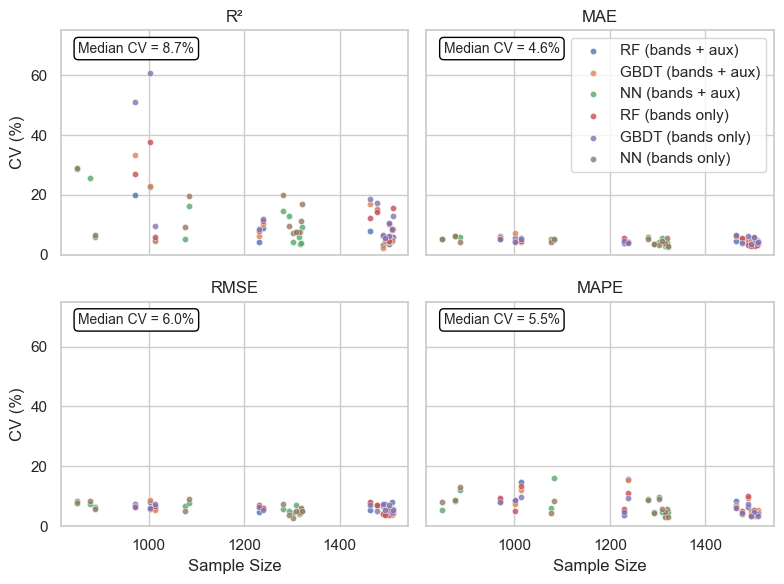

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
metrics = ['R_squared', 'MAE', 'RMSE', 'MAPE']
cv_medians = {metric: [] for metric in metrics}

for model_name in model_names:
    sample_sizes = get_sample_size(model_name)
    model_results = [res for res in leaderboard if res['model_path'] == model_name][0]['results']

    for i, metric in enumerate(metrics):
        label = labels[model_name]
        legend = True if i == 1 else False

        cv = {var: model_results[var][f'{metric}_std'] / model_results[var][f'{metric}_mean'] * 100 for var in VARS}
        cv_medians[metric].append(list(cv.values()))
        ax = axs.flat[i]

        sns.scatterplot(
            x=sample_sizes.values(),
            y=cv.values(),
            s=20,
            alpha=0.8,
            label=label,
            ax=ax,
            legend=legend
        )
        title = 'R²' if metric == 'R_squared' else metric
        ax.set_title(f'{title}')
        ax.set_xlabel('Sample Size')
        ax.set_ylabel(f'CV (%)')
        ax.set_ylim(0, 75)

# Calculate mean value for CV across models.
cv_medians = {metric: np.median(cv_means[metric]) for metric in metrics}
for i, cv_median in enumerate(cv_medians.values()):
    ax = axs.flat[i]
    ax.text(
        0.05,
        0.95,
        f'Median CV = {cv_median:.1f}%',
        ha='left',
        va='top',
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
    )

plt.tight_layout()

In [31]:
cv

{'N.Percent': 3.0925536017346262,
 'P.Percent': 5.704673900191733,
 'K.Percent': 4.773176504883542,
 'Ca.Percent': 9.146666770113624,
 'Mg.Percent': 3.2423154897023876,
 'C.Percent': 4.546108190636873,
 'Amax': 13.170472513582096,
 'Asat': 8.270299277045174,
 'Area.cm2': 8.630461718779303,
 'Dry.mass.g': 8.14922336480123,
 'Fresh.mass.g': 8.874819431268007,
 'Thickness.mm': 5.809900363474032,
 'SLA.g.m2': 4.557030630664914}